Goal: This script adds an adaptive pooling layer to [this](https://github.com/arvindkrishna87/STAT390_WI2025/blob/a90ac97e593db9953ff84f22a33382476c8faeb6/Presentation%205/Coders/Nathan%20Jung/CNN%20model.ipynb) CNN model made last quarter by Nathan and evaluates how the model performs relative to the model without an adaptive pooling layer.

Author: David Gormley

Last Modified: 5/13/25

Structure

1) Import Dependencies and mount drive

2) Train Model

3) Evaluate Model

4) Adjust Threshold

Key Issue
- Folder is missing some of the cases that Krish identified as good cases
    - Here are the cases Krish identified as good
      - train_cases  = [2,1,22,9,34,38,53,55,78,62,85,89,21,3,45,49]
      - test_cases   = [77,60,79,70,90,92,25,12]

    - Here are the cases that we actually have
      - true_train = [1,2,3,9,53,55,78,85,89]
      - true_test = [12,60,77,79,90,92]



**1) Import Dependencies and mount drive**

In [ ]:
# stdlib
import os
import glob
import re
import struct
from concurrent.futures import ThreadPoolExecutor, as_completed

# data & imaging
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader

# torchvision
import torchvision
from torchvision import transforms

# metrics & plotting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Colab
from google.colab import drive

In [ ]:
# ─── 1) MOUNT GOOGLE DRIVE ──────────────────────────────────────────────
drive.mount('/content/drive', force_remount=True)

# ─── 2) DEVICE & CUDNN ──────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True  # auto‐tune for fixed input sizes

Mounted at /content/drive


**2. Train Model**
- We can adjust the following
    - Restricting image size: min and max image width used for training and evaluation
    - Stain type
    - Train and test cases

In [ ]:
import os
import re
import struct
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import functional as F
from torchvision.transforms.functional import pad
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# ─── A) HELPER: ONLY RESIZE LARGE IMAGES ─────────────────────────────────
class ResizeIfLarge:
    def __init__(self, max_side=400):
        self.max_side = max_side
    def __call__(self, img):
        w, h = img.size
        if max(w, h) > self.max_side:
            scale = self.max_side / max(w, h)
            return F.resize(img, (int(h*scale), int(w*scale)))
        return img

# ─── 1) CONFIG ──────────────────────────────────────────────────────────
image_folder   = "/content/drive/MyDrive/'25 Spring/390/CMIL_SP2025_Patches_Apr27"
train_cases    = [92,78,55,60,49,45,38,53,9,22,77,79,70]
test_cases     = [34,1,99,62,89,2,12,90,21,3,85,25,98]
all_cases      = set(train_cases + test_cases)
batch_size     = 32
num_workers    = 2
lr             = 1e-3
num_epochs     = 10
min_width, max_width = 50, 10000
meta_csv       = '/content/drive/MyDrive/patch_metadata.csv'
force_rebuild  = False
device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─── 2) LOAD LABELS ──────────────────────────────────────────────────────
labels_df = pd.read_csv("/content/drive/MyDrive/'25 Spring/390/case_grade_match.csv") \
              .drop(index=64, errors='ignore').reset_index(drop=True)
class_map = {int(r.Case): (0 if r.Class==1 else 1) for _,r in labels_df.iterrows()}

# ─── 3) METADATA ─────────────────────────────────────────────────────────
case_pat = re.compile(r'case_0*(\d+)_(?:match|unmatched)_', re.IGNORECASE)
def fast_scan(root):
    for e in os.scandir(root):
        if e.is_file() and e.name.endswith('.png'):
            yield e.path
        elif e.is_dir():
            yield from fast_scan(e.path)

def build_metadata():
    if os.path.exists(meta_csv) and not force_rebuild:
        df = pd.read_csv(meta_csv)
        if {'path','case_number','stain','width','height'}.issubset(df.columns):
            return df
    files = list(fast_scan(image_folder))
    def proc(p):
        m = case_pat.search(os.path.basename(p))
        if not m: return None
        cid = int(m.group(1))
        if cid not in all_cases: return None
        stain = 'h&e' if 'h&e' in p.lower() else None
        if not stain: return None
        w,h = -1,-1
        try:
            with open(p,'rb') as f:
                hdr = f.read(24)
            if len(hdr)>=24:
                w = struct.unpack('>I',hdr[16:20])[0]
                h = struct.unpack('>I',hdr[20:24])[0]
        except:
            pass
        return {'path':p,'case_number':cid,'stain':stain,'width':w,'height':h}
    with ThreadPoolExecutor(8) as exe:
        rows = list(tqdm(exe.map(proc, files), total=len(files), desc="Scanning"))
    df = pd.DataFrame([r for r in rows if r])
    df.to_csv(meta_csv, index=False)
    return df

df_meta = build_metadata()
df_meta = df_meta[df_meta.case_number.isin(all_cases)]
df_meta = df_meta[((df_meta.width>min_width)&(df_meta.width<max_width))|(df_meta.width==-1)]
df_meta = df_meta[df_meta.stain=='h&e']
df_train = df_meta[df_meta.case_number.isin(train_cases)]
df_test  = df_meta[df_meta.case_number.isin(test_cases)]
train_paths, test_paths = df_train.path.tolist(), df_test.path.tolist()

# ─── 4) TRANSFORMS ────────────────────────────────────────────────────────
train_transform = transforms.Compose([
    ResizeIfLarge(512),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
test_transform = transforms.Compose([
    ResizeIfLarge(512),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ─── 5) DATASET & PAD-COLLATE ────────────────────────────────────────────
class CaseDataset(Dataset):
    def __init__(self, paths, cmap, transform):
        self.paths, self.cmap, self.transform = paths, cmap, transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        try:
            img = Image.open(p).convert('RGB')
        except:
            return None
        img = self.transform(img)
        cid = int(case_pat.search(os.path.basename(p)).group(1))
        lbl = self.cmap[cid]
        return img, lbl, cid

def collate_fn(batch):
    batch = [b for b in batch if b]
    imgs, lbls, cids = zip(*batch)
    H = max(img.shape[1] for img in imgs)
    W = max(img.shape[2] for img in imgs)
    padded = [pad(img, (0,0,W-img.shape[2],H-img.shape[1])) for img in imgs]
    return torch.stack(padded), torch.tensor(lbls), torch.tensor(cids)

train_loader = DataLoader(CaseDataset(train_paths,class_map,train_transform),
                          batch_size=batch_size,shuffle=True,
                          num_workers=num_workers,pin_memory=False,
                          collate_fn=collate_fn)
test_loader  = DataLoader(CaseDataset(test_paths, class_map,test_transform),
                          batch_size=batch_size,shuffle=False,
                          num_workers=num_workers,pin_memory=False,
                          collate_fn=collate_fn)

# ─── 6) MODEL SETUP ─────────────────────────────────────────────────────
model = models.alexnet(pretrained=True)
for p in model.parameters(): p.requires_grad=False
model.features = nn.Sequential(*list(model.features),
                               nn.AdaptiveAvgPool2d((6,6)))
in_ftrs = 256*6*6
model.classifier = nn.Sequential(
    nn.Dropout(), nn.Linear(in_ftrs,4096), nn.ReLU(inplace=True),
    nn.Dropout(), nn.Linear(4096,4096), nn.ReLU(inplace=True),
    nn.Linear(4096,2)
)
model.to(device)
opt = optim.Adam(model.classifier.parameters(), lr=lr)
crit = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True

# ─── 7) TRAIN ────────────────────────────────────────────────────────────
for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0; total_n = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    for batch in pbar:
        imgs, lbls, _ = batch
        imgs, lbls = imgs.to(device), lbls.to(device)
        opt.zero_grad()
        with torch.cuda.amp.autocast():
            loss = crit(model(imgs), lbls)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        total_loss += loss.item()*imgs.size(0)
        total_n += imgs.size(0)
        pbar.set_postfix(loss=f"{total_loss/total_n:.4f}")
    print(f"Epoch {epoch} Loss: {total_loss/total_n:.4f}")

# ─── 8) EVAL + THRESHOLD SWEEP ───────────────────────────────────────────
model.eval()
probs_list, labels_list = [], []
with torch.no_grad():
    for batch in test_loader:
        imgs, lbls, _ = batch
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.softmax(logits,dim=1)[:,1]
        probs_list.append(probs.cpu())
        labels_list.extend(lbls.tolist())

probs = torch.cat(probs_list)
labels = np.array(labels_list, dtype=int)

# find threshold maximizing accuracy
thresholds = torch.linspace(0,1,201)
best_acc, best_t = 0, 0
for t in thresholds:
    preds = (probs>t).int().numpy()
    acc = accuracy_score(labels, preds)
    if acc>best_acc:
        best_acc, best_t = acc, t.item()

print(f"Best threshold for accuracy: {best_t:.3f} (acc={best_acc:.4f})")

# final metrics & confusion matrix
final_preds = (probs>best_t).int().numpy()
print(f"Precision: {precision_score(labels,final_preds):.4f}")
print(f"Recall:    {recall_score(labels,final_preds):.4f}")
print(f"F1 Score:  {f1_score(labels,final_preds):.4f}")

cm = confusion_matrix(labels, final_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["0","1"])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix @ t={best_t:.3f}")
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 152MB/s]
<ipython-input-3-22d74a727cfb>:158: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.G

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-22d74a727cfb>", line 166, in <cell line: 0>
    for batch in pbar:
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 701, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1448, in _next_data
    idx, data = self._get_data()
                ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1412, in _get_data
    success, data = self._try_get_data()
                    ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", li

TypeError: object of type 'NoneType' has no len()

**3) Evaluate Model**

In [ ]:
# ─── 9) PATCH‐LEVEL EVALUATION ───────────────────────────────────────────
model.eval()
all_preds, all_labels = [], []
correct, total = 0, 0

with torch.no_grad():
    # MODIFICATION: Unpack all three items from the test_loader
    for images, labels, case_ids in test_loader:
        # Handle potential None batch if using the collate_fn_skip_none
        if images is None: # Check images as a proxy for the whole batch being None
             # print("[WARN] Skipping an empty batch during evaluation.") # Uncomment for debugging
             continue # Skip this batch

        images, labels = (images.to(device, non_blocking=True),
                          labels.to(device, non_blocking=True))
        outputs = model(images)
        preds   = outputs.argmax(dim=1)

        # You were already collecting preds and labels correctly after this
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total   += labels.size(0) # Use labels.size(0) or preds.size(0) or images.size(0) for actual batch size

# The rest of your code for calculating metrics is correct
accuracy  = 100 * correct / total if total > 0 else 0 # Add check for total > 0
precision = precision_score(all_labels, all_preds)
recall    = recall_score(all_labels, all_preds)
f1        = f1_score(all_labels, all_preds)

print(f"Test Patch‐level Accuracy : {accuracy:.2f}%")
print(f"Precision                : {precision:.4f}")
print(f"Recall                   : {recall:.4f}")
print(f"F1 Score                 : {f1:.4f}")

print(f"Total test patches evaluated: {total}")
print(f"Correct predictions         : {correct}")

# Note: case_ids are available in the loop if you need them for per-patch analysis later,
# but they are not used in this specific patch-level metric calculation block.
# The per-case metrics calculation block you had previously *does* use case_ids.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Patch‐level Accuracy : 87.99%
Precision                : 0.8411
Recall                   : 0.9446
F1 Score                 : 0.8899
Total test patches evaluated: 633
Correct predictions         : 557


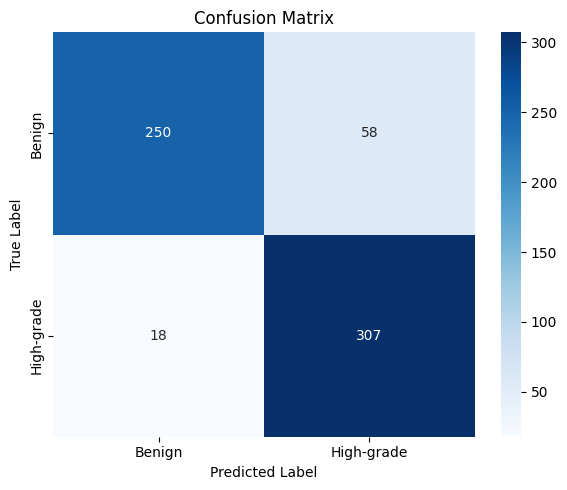

In [ ]:
# ─── CONFUSION MATRIX ────────────────────────────────────────────────────
cm = confusion_matrix(all_labels, all_preds)
labels = ['Benign', 'High-grade']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

**4) Adjusting Threshold**

In [ ]:
model.eval()
probs, labels = [], []

with torch.no_grad():
    for batch in test_loader:
        if batch is None: continue
        imgs, lbls, _ = batch
        imgs = imgs.to(device)

        outputs = model(imgs)
        softmax_probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 1

        probs.append(softmax_probs.cpu())
        labels.extend(lbls)  # Python list is OK here

probs = torch.cat(probs)
labels = torch.tensor(labels)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

thresholds = torch.linspace(0, 1, 201)
best_acc = 0
best_thresh = 0

for t in thresholds:
    preds = (probs > t).int().numpy()
    acc = accuracy_score(labels.numpy(), preds)
    if acc > best_acc:
        best_acc = acc
        best_thresh = t.item()

print(f"✅ Best threshold for accuracy: {best_thresh:.3f}")
print(f"🔍 Accuracy at best threshold: {best_acc:.4f}")


✅ Best threshold for accuracy: 0.695
🔍 Accuracy at best threshold: 0.8863


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert predictions and labels to NumPy arrays
final_preds = (probs > best_thresh).int().numpy()
true_labels = labels.numpy()


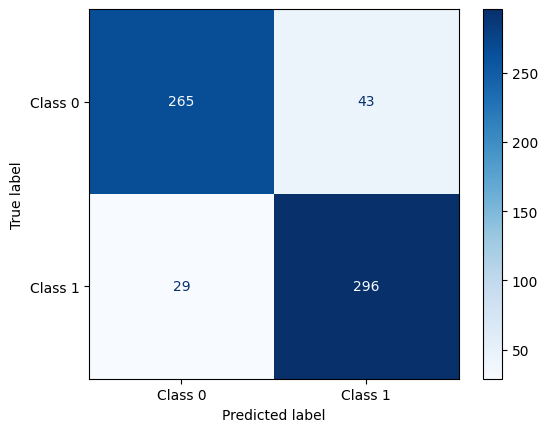

In [ ]:
cm = confusion_matrix(true_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap='Blues', values_format='d')


Best Threshold: 0.76
Accuracy:  0.9179
Precision: 0.9306
Recall:    0.9077
F1 Score:  0.9190


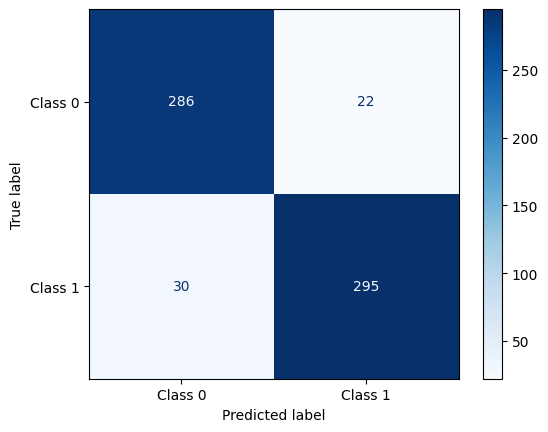

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Apply threshold
final_preds = (probs > best_thresh).int().numpy()
true_labels = labels.numpy()

# Step 2: Compute metrics
acc  = accuracy_score(true_labels, final_preds)
prec = precision_score(true_labels, final_preds, zero_division=0)
rec  = recall_score(true_labels, final_preds, zero_division=0)
f1   = f1_score(true_labels, final_preds, zero_division=0)

# Step 3: Print metrics
print(f"Best Threshold: {best_thresh:.2f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Step 4: Confusion matrix
cm = confusion_matrix(true_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap='Blues', values_format='d')
